# BioSoc Bioinformatics Sessions: Analysis of Single-cell RNA data
### Pete Dockrill, Thursday 13th June 2024

In [1]:
## Comment or uncomment the following three lines to install the necessary R packages:
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages('Seurat')

In [2]:
#system("wget https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [3]:
#system("gzip -d pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [4]:
#system("tar -xvf pbmc3k_filtered_gene_bc_matrices.tar -o filtered_gene_bc_matrices")

In [5]:
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




## Review of last session

First, load the data:

In [6]:
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


We then filter the data to remove dying cells and bad reads:

In [7]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc <- NormalizeData(pbmc)

Normalizing layer: counts



We also found the most variable features and scaled the data, which allowed us to reduce the dimensions of the dataset using Principal Component Analysis:

In [8]:
#Find most variable features
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

#Scale data 
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

#Run PCA
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XC

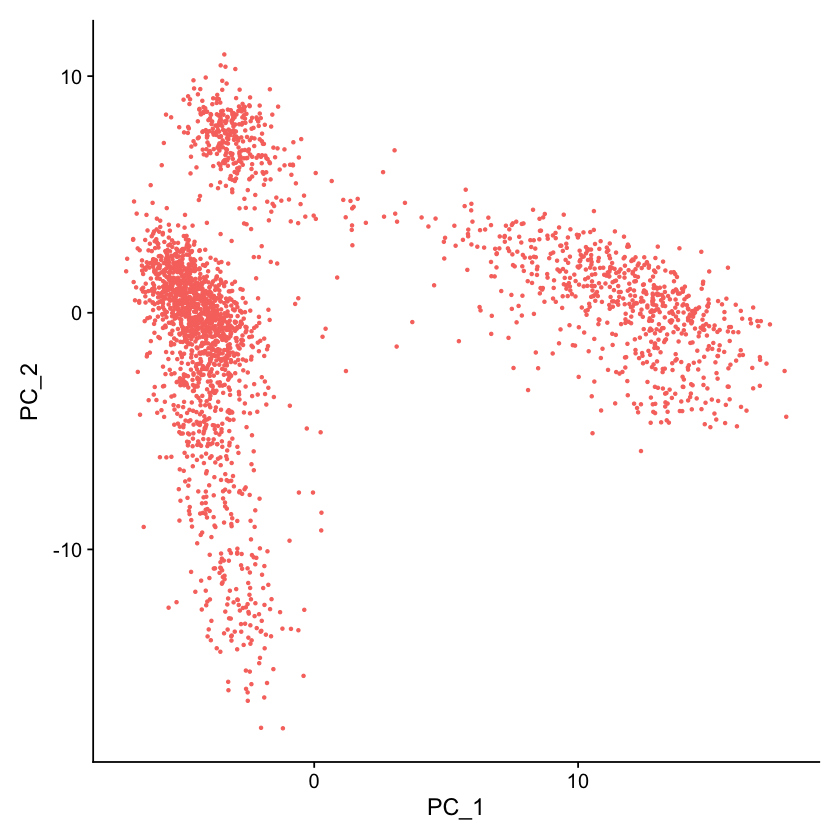

In [9]:
DimPlot(pbmc, reduction = "pca") + NoLegend()

## Clustering

If we look closely at the PC plot above, we can see that the data isn't uniformly distributed across the space - certain data points tend to group around specific areas of the space.

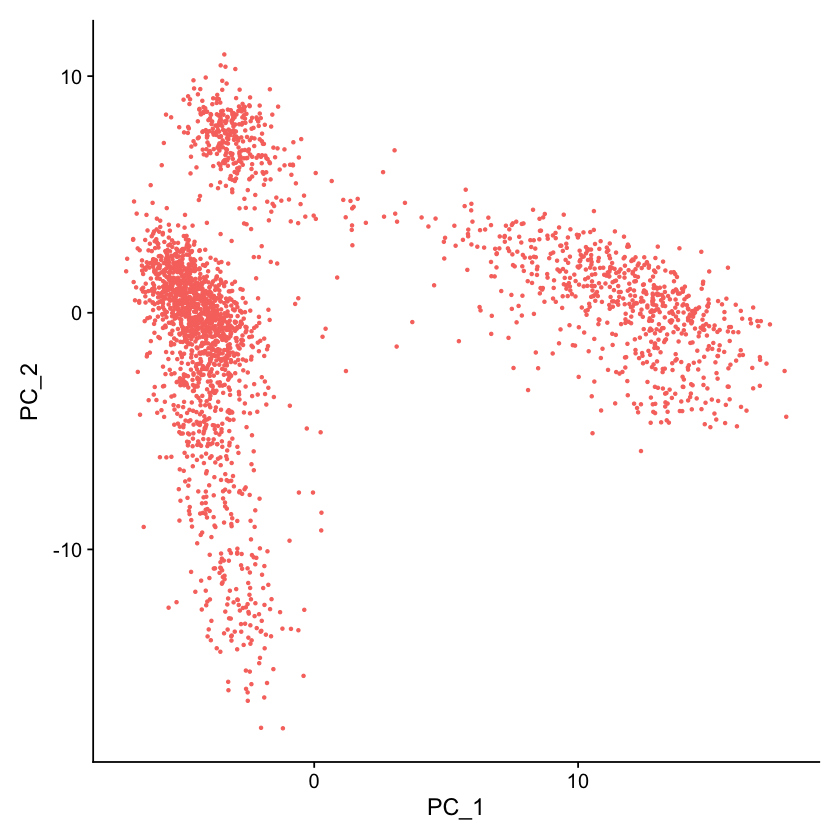

In [10]:
DimPlot(pbmc, reduction = "pca") + NoLegend()

This is known as ***clustering***.

We can use R to identify the clusters that form in the data:

In [11]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


We can now see that the clustering algorithm has identified 9 clusters, labelled 0 - 9:

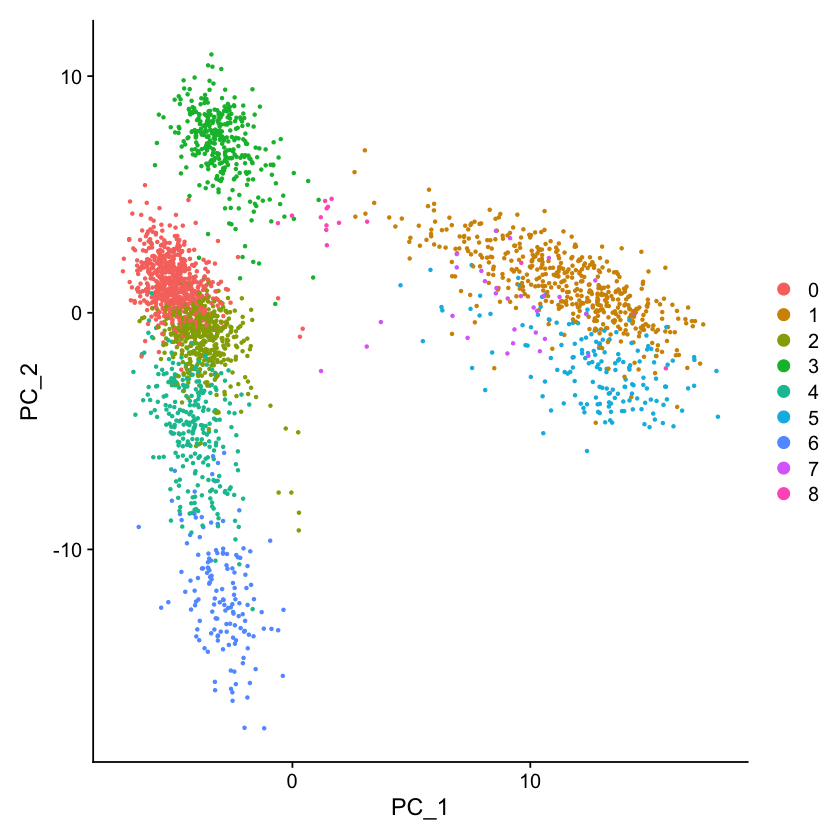

In [12]:
DimPlot(pbmc, reduction = "pca") 

## Finding marker genes

We now want to find the genes that are contained in each cluster, known as 'Marker' genes:

In [13]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [27]:
top_10_genes <- pbmc.markers %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 1) %>%
  filter(cluster == 0) %>%
  slice_head(n = 10) %>%
  select(gene)

print(top_10_genes)

Adding missing grouping variables: `cluster`


# A tibble: 10 × 2
# Groups:   cluster [1]
   cluster gene     
   <fct>   <chr>    
 1 0       LDHB     
 2 0       CCR7     
 3 0       CD3D     
 4 0       CD3E     
 5 0       LEF1     
 6 0       NOSIP    
 7 0       PRKCQ-AS1
 8 0       PIK3IP1  
 9 0       FHIT     
10 0       MAL      


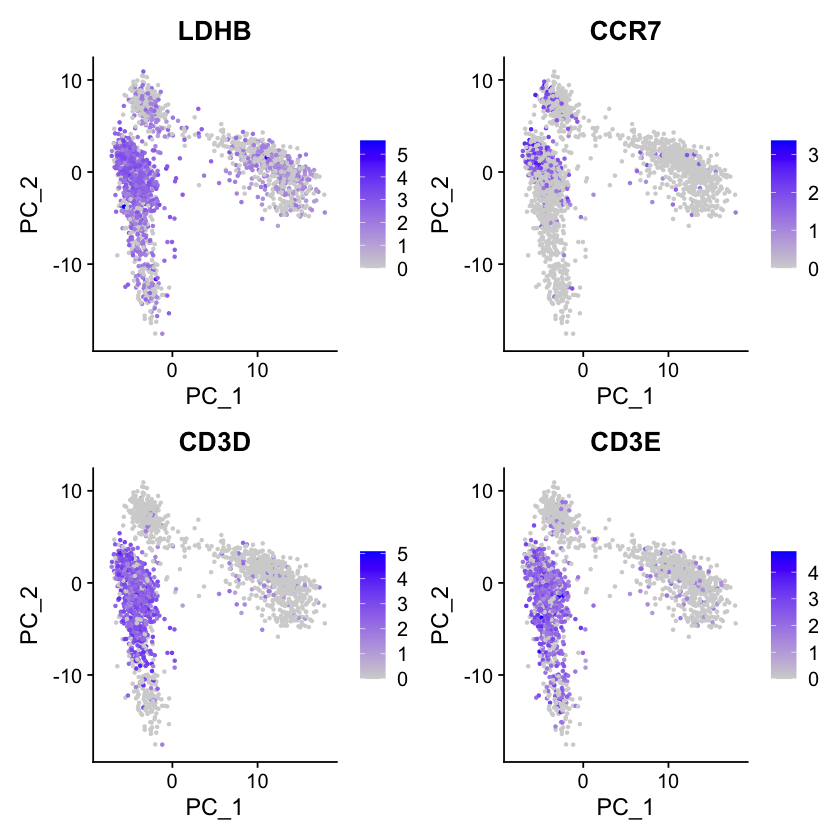

In [15]:
FeaturePlot(pbmc, reduction = "pca", features = c("LDHB","CCR7","CD3D","CD3E"))

### Task 1

Look up each of the top 10 genes in cluster 0 using Uniprot and consider their function.

Extension: repeat for other clusters, e.g cluster 4:

In [19]:
top_10_genes <- pbmc.markers %>%
  group_by(cluster) %>%
  filter(avg_log2FC > 1) %>%
  filter(cluster == 4) %>%
  slice_head(n = 10) %>%
  select(gene)

print(top_10_genes)

Adding missing grouping variables: `cluster`


# A tibble: 10 × 2
# Groups:   cluster [1]
   cluster gene 
   <fct>   <chr>
 1 4       CCL5 
 2 4       NKG7 
 3 4       CST7 
 4 4       GZMA 
 5 4       GZMK 
 6 4       CTSW 
 7 4       KLRG1
 8 4       CD8A 
 9 4       GZMH 
10 4       LYAR 


## Cell type inference

### Cell types and gene expression

Cell types can be 'defined' according to the genes that they express.

If a particular cell expresses a particular gene such as CD28, we say that the cell is **CD28 positive (CD28+)** 

All cells begin as stem cells which ***differentiate*** into a particular type by expressing a combination of genes that allow the cell to carry out a particular function. 

For example, cytotoxic T cells (also known as 'killer' T cells) are ***CD8 positive*** because the CD8 protein allows them to bind and destroy cells that have been infected by a virus.

Expressing the genes that produce a T cell receptor (such as CD3) 'defines' the cell as a T cell, but the expression of CD8 'defines' the cell as a cytotoxic T cell, a T cell ***subtype***. 

### Cell type inference

We will now attempt to associate ***cell types*** with ***clusters*** in the data.

Given a gene or set of genes, we can search for cell types using a database like [PanglaoDB](https://panglaodb.se/index.html):

<img src="Images/PanglaoDBSearch.png" width="1200">

<img src="Images/PanglaoDBResults.png" width="1200">

<img src="Images/PanglaoDBChart.png" width="1200">

We see that the cells in cluster 4 are expressing **CD8A**, a component of the CD8 protein complex:

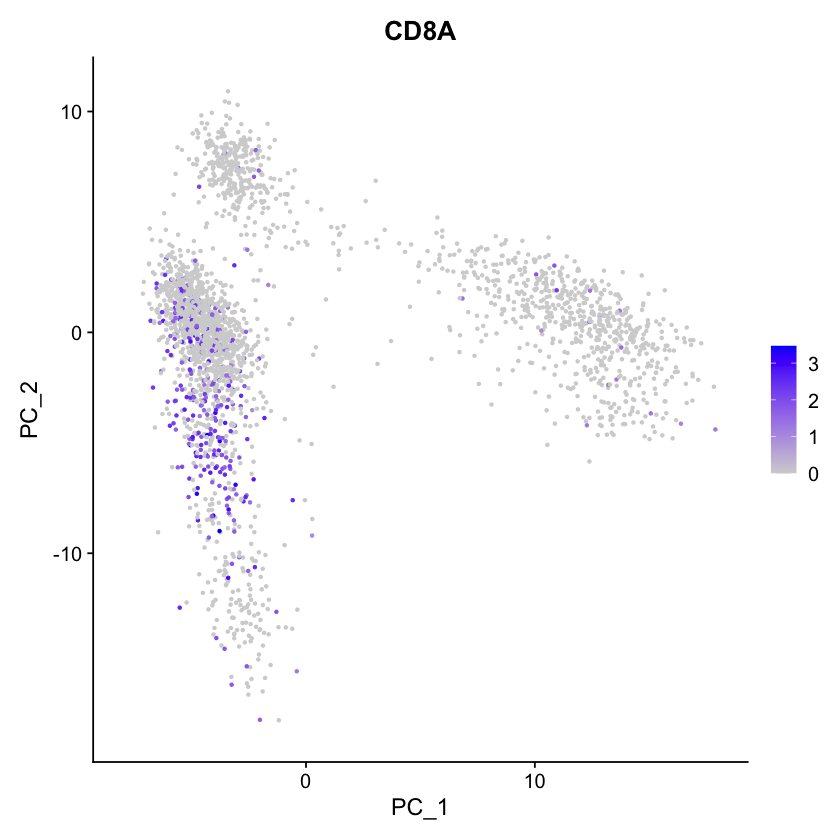

In [17]:
FeaturePlot(pbmc, reduction = "pca", features = c("CD8A"))

As discussed above, the CD8 protein is expressed by cytotoxic T cells, implying that cluster 4 mostly consists of cytotoxic T cells. 

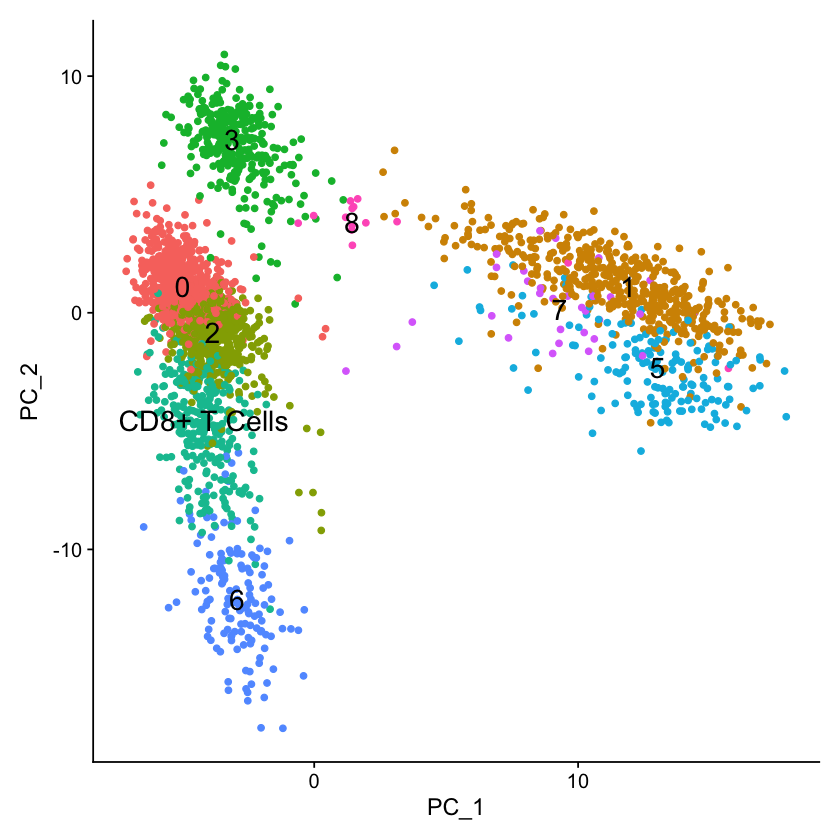

In [18]:
new.cluster.ids <- c("0", "1", "2", "3", "CD8+ T Cells", "5",
    "6", "7", "8")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "pca", label = TRUE, pt.size = 1.5, label.size = 6) + NoLegend()

### Task 2

Given the marker genes that we found in the previous step, identify the cell types contained in each of the remaining clusters.